In [15]:
import numpy as np
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

# ----------------------------
# 1) Load dataset from Hugging Face
# ----------------------------
hf_ds = load_dataset("Ad10sKun/phishing_detection")
test_hf = hf_ds["test"]  # use test split

# Convert to lists
texts = test_hf["text"]
labels = test_hf["label"]

print("HF test size:", len(texts))
print("Label counts:", {0: labels.count(0), 1: labels.count(1)})

# ----------------------------
# 2) Load your saved model + tokenizer
# ----------------------------
MODEL_DIR = "smish_detection_model/final_model"

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

MAX_LEN = 95

# ----------------------------
# 3) Create Dataset + DataLoader
# ----------------------------
class HFTextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
            return_tensors="pt"
        )

        return {
            "input_ids": enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels": torch.tensor(label, dtype=torch.long)
        }

test_dataset = HFTextDataset(texts, labels, tokenizer, max_length=MAX_LEN)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# ----------------------------
# 4) Run inference
# ----------------------------
all_logits = []
all_true = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        y = batch["labels"].cpu().numpy()

        out = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = out.logits.cpu().numpy()

        all_logits.append(logits)
        all_true.append(y)

all_logits = np.vstack(all_logits)
all_true = np.concatenate(all_true)

preds = np.argmax(all_logits, axis=1)

# ----------------------------
# 5) Compute metrics
# ----------------------------
acc = accuracy_score(all_true, preds)
prec, rec, f1, _ = precision_recall_fscore_support(all_true, preds, average="binary", zero_division=0)

cm = confusion_matrix(all_true, preds, labels=[0, 1])

print("\n✅ Evaluation on HF phishing_detection (test split)")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall   : {rec:.4f}")
print(f"F1-score : {f1:.4f}")
print("\nConfusion Matrix:\n", cm)


HF test size: 3330
Label counts: {0: 1322, 1: 2008}

✅ Evaluation on HF phishing_detection (test split)
Accuracy : 0.5916
Precision: 0.6146
Recall   : 0.8650
F1-score : 0.7187

Confusion Matrix:
 [[ 233 1089]
 [ 271 1737]]


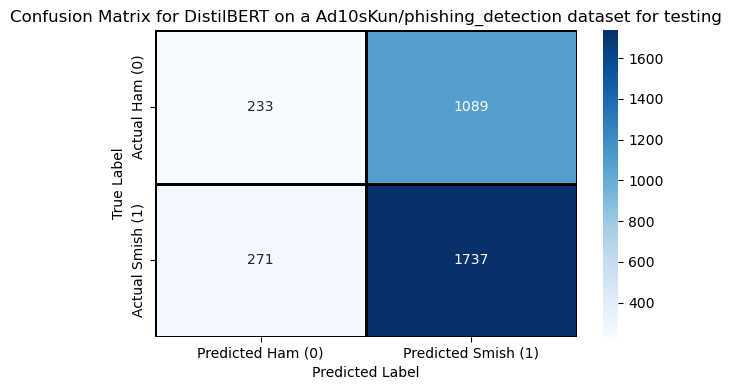

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Your confusion matrix values (already computed)
cm = [[233, 1089],
      [271, 1737]]

# Plot
plt.figure(figsize=(6, 4))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=1,
    linecolor="black",
    xticklabels=["Predicted Ham (0)", "Predicted Smish (1)"],
    yticklabels=["Actual Ham (0)", "Actual Smish (1)"]
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for DistilBERT on a Ad10sKun/phishing_detection dataset for testing")
plt.tight_layout()
plt.show()
